<a href="https://colab.research.google.com/github/arii-m/Datmin_Kelompok-6/blob/main/datmin_eda_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FORECASTING HARGA RATA-RATA MOBIL/TAHUN**






---

# Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Load dataset
df = pd.read_csv('/content/cars_dataframe.csv')
df.head()

,Brand,Model,Year,Condition,Mileage,Gearbox,Fiscal Power,Fuel,Equipment,Number of Doors,Origin,First Owner,Location,Sector,Price
0,Volkswagen,Polo,1997,Good,200 000 - 249 999,Manual,8 CV,Diesel,"['Leather Seats', 'CD/MP3/Bluetooth']",NaN,NaN,NaN,Tétouan,City Center,27000.0
1,Dacia,Sandero,2012,Very Good,180 000 - 189 999,Manual,6 CV,Diesel,"['Rear Camera', 'Electric Windows']",5.0,WW in Morocco,No,Temara,City Center,69000.0
2,Volkswagen,Polo,2004,Fair,300 000 - 349 999,Manual,8 CV,Diesel,"['Alloy Wheels', 'Electric Windows']",5.0,WW in Morocco,No,Safi,Chenguite,45000.0
3,Bentley,Continental gtc,2009,Excellent,45 000 - 49 999,Automatic,34 CV,Petrol,"['Rear Camera', 'Electric Windows']",3.0,Customs-cleared car,Yes,Casablanca,Aïn Chock,720000.0
4,mini,cooper,2013,Excellent,85 000 - 89 999,Automatic,8 CV,Diesel,"['Airbags', 'CD/MP3/Bluetooth', 'Rear Camera',...",5.0,WW in Morocco,No,Fès,Agdal,128000.0


# EDA

## Cek Struktur Data

In [3]:
info_df = pd.DataFrame({
    "Kolom": df.columns,
    "Tipe Data": df.dtypes.values,
    "Jumlah Null": df.isnull().sum().values,
    "Jumlah Unique": df.nunique().values
     })
display(info_df)

,Kolom,Tipe Data,Jumlah Null,Jumlah Unique
0,Brand,object,1,81
1,Model,object,1,1049
2,Year,object,0,45
3,Condition,object,3583,7
4,Mileage,object,1,37
5,Gearbox,object,0,2
6,Fiscal Power,object,280,39
7,Fuel,object,0,6
8,Equipment,object,0,10551
9,Number of Doors,float64,11415,2


### Konversi ke Numerik

In [4]:
# Mileage
def mileage_to_num(mileage_str):
    if pd.isna(mileage_str):
        return np.nan
    if mileage_str == 'Plus de 500 000':
        return 500000  # atau angka lain sebagai batas atas
    try:
        parts = mileage_str.split('-')
        low = int(parts[0].strip().replace(' ', ''))
        high = int(parts[1].strip().replace(' ', ''))
        return (low + high) / 2
    except:
        return np.nan

df['mileage_num'] = df['Mileage'].apply(mileage_to_num)
# df['mileage_num'] = df['mileage_num'].fillna(0).astype(int)


# Fiscal Power '8 CV' -> 8
df['Fiscal Power'] = df['Fiscal Power'].astype(str).str.extract(r'(\d+)')
df['Fiscal Power'] = pd.to_numeric(df['Fiscal Power'], errors='coerce').astype('Int64') # Use nullable integer type

# Number of Doors
df['Number of Doors'] = df['Number of Doors'].fillna(0).astype(int)

### Clean kolom "Year"

In [5]:
def clean_year(value):
    if isinstance(value, str) and '1980' in value:
        return 1980
    try:
        return int(value)
    except:
        return None

df['Year'] = df['Year'].apply(clean_year)
df = df.dropna(subset=['Year'])
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

### Cek Missing Values

In [6]:
df.isnull().sum()

,0
Brand,1
Model,1
Year,0
Condition,3583
Mileage,1
Gearbox,0
Fiscal Power,280
Fuel,0
Equipment,0
Number of Doors,0


<Axes: >

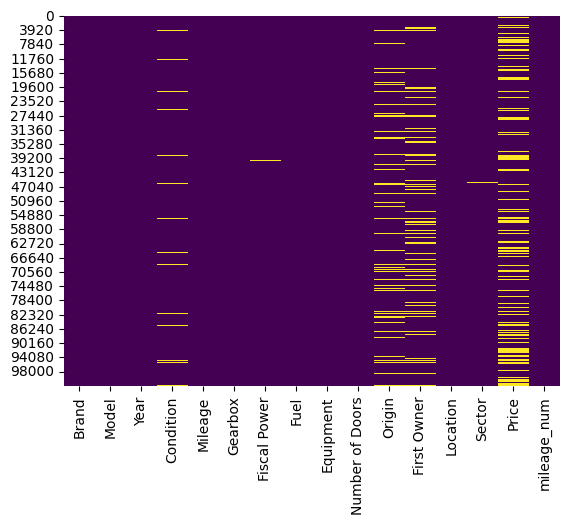

In [7]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")

### Filter Outlier

In [8]:
df = df[df['Price'] < 500000]

Brand
Renault          9371
Volkswagen       8898
Peugeot          7023
Dacia            6290
Mercedes-Benz    5068
Name: count, dtype: int64
Fuel
Diesel             59483
Petrol             14323
Hybrid               550
Electrique           175
LPG                   44
35 000 - 39 999        1
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='Brand'>

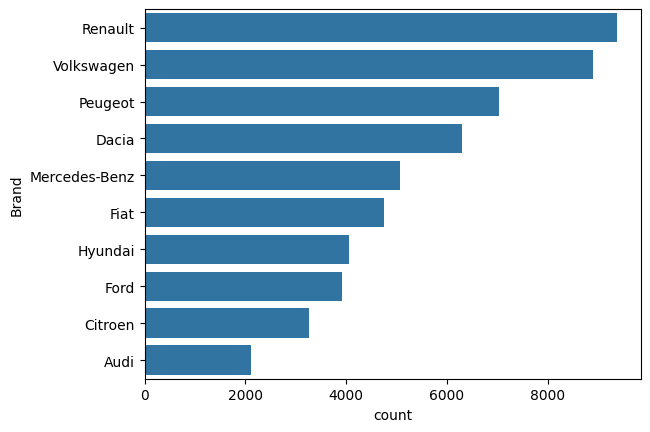

In [9]:
# cek distribusi kolom kategorikal
print(df['Brand'].value_counts().head())
print(df['Fuel'].value_counts())
sns.countplot(y='Brand', data=df, order=df['Brand'].value_counts().iloc[:10].index)

## Statistik Deskriptif Kolom Numerik

In [10]:
df.describe()

,Year,Fiscal Power,Number of Doors,Price,mileage_num
count,74576,74373.0,74576.000000,74576.000000,74575.000000
mean,2011-07-07 23:03:13.863977728,7.429538,4.398077,127003.608332,141649.621991
min,1980-01-01 00:00:00,4.0,0.000000,1.000000,2499.500000
25%,2007-01-01 00:00:00,6.0,5.000000,60000.000000,57499.500000
50%,2013-01-01 00:00:00,7.0,5.000000,107000.000000,134999.500000
75%,2018-01-01 00:00:00,8.0,5.000000,165000.000000,194999.500000
max,2024-01-01 00:00:00,41.0,5.000000,499000.000000,500000.000000
std,NaN,2.679515,1.516711,91251.894856,102838.637718


In [11]:
print("Statistik Harga Mobil Bekas:")
print(f"- Minimum: {df['Price'].min():,.0f} MAD")
print(f"- Maksimum: {df['Price'].max():,.0f} MAD")
print(f"- Rata-rata: {df['Price'].mean():,.0f} MAD")
print(f"- Median: {df['Price'].median():,.0f} MAD")

Statistik Harga Mobil Bekas:
- Minimum: 1 MAD
- Maksimum: 499,000 MAD
- Rata-rata: 127,004 MAD
- Median: 107,000 MAD


📊 Insight Statistik Harga Mobil Bekas
- Berdasarkan data yang telah difilter (harga < 500.000 MAD), diketahui bahwa harga minimum mobil bekas adalah 1 MAD, sedangkan harga maksimum mencapai 499.000 MAD.

- Rata-rata harga mobil bekas berada di angka 127.004 MAD, sementara median harga adalah 107.000 MAD.

- Nilai rata-rata yang lebih tinggi dibanding median mengindikasikan bahwa distribusi harga cenderung skewed ke kanan (positively skewed), artinya sebagian kecil mobil memiliki harga yang jauh lebih tinggi dari mayoritas.

- Rentang harga yang sangat luas ini menunjukkan adanya variasi besar dalam jenis mobil bekas yang ditawarkan — mulai dari mobil sangat murah hingga mobil dengan harga tinggi.

- Poin ini penting untuk mempertimbangkan pemilihan metode prediksi yang robust dan tidak terlalu sensitif terhadap outlier.

##  Distribusi Harga Mobil Bekas

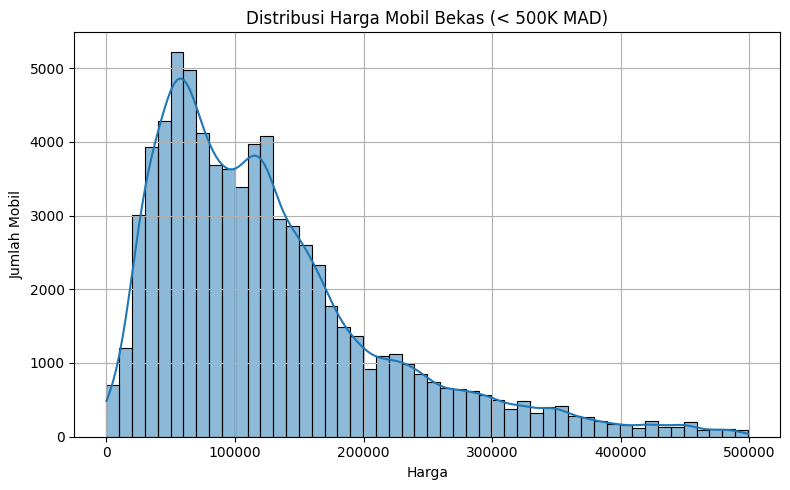

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(df[df['Price'] < 500000]['Price'], bins=50, kde=True)
plt.title("Distribusi Harga Mobil Bekas (< 500K MAD)")
plt.xlabel("Harga")
plt.ylabel("Jumlah Mobil")
plt.grid(True)
plt.tight_layout()
plt.show()

- Data menunjukkan variasi harga yang sangat besar, dengan rentang antara nilai minimum dan maksimum yang jauh.
- Median harga mobil bekas cenderung lebih rendah daripada nilai rata-rata, menunjukkan adanya **outlier**, yaitu mobil-mobil dengan harga sangat tinggi (kemungkinan mobil mewah atau data tidak valid).
- Distribusi harga menunjukkan kecenderungan **positively skewed** >> sebagian besar mobil berada di harga menengah ke bawah.
- Langkah berikutnya seperti transformasi log harga bisa dipertimbangkan, namun untuk ARIMA univariat, cukup pahami persebaran ini terlebih dahulu.


Text(0.5, 1.0, 'Distribusi Harga Mobil Bekas')

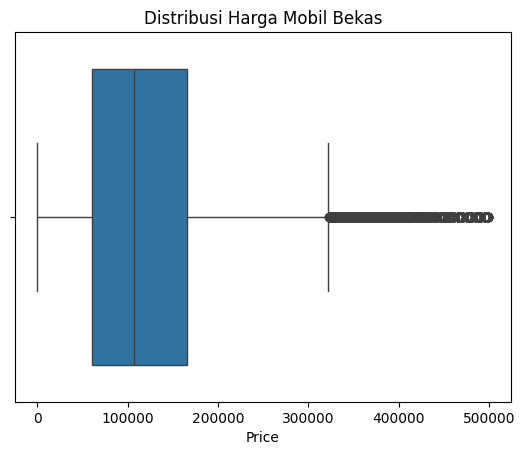

In [13]:
# Boxplot harga untuk melihat outlier
sns.boxplot(x=df['Price'])
plt.title("Distribusi Harga Mobil Bekas")

## Distribusi Kategorikal

### Boxplot Harga Berdasarkan Brand

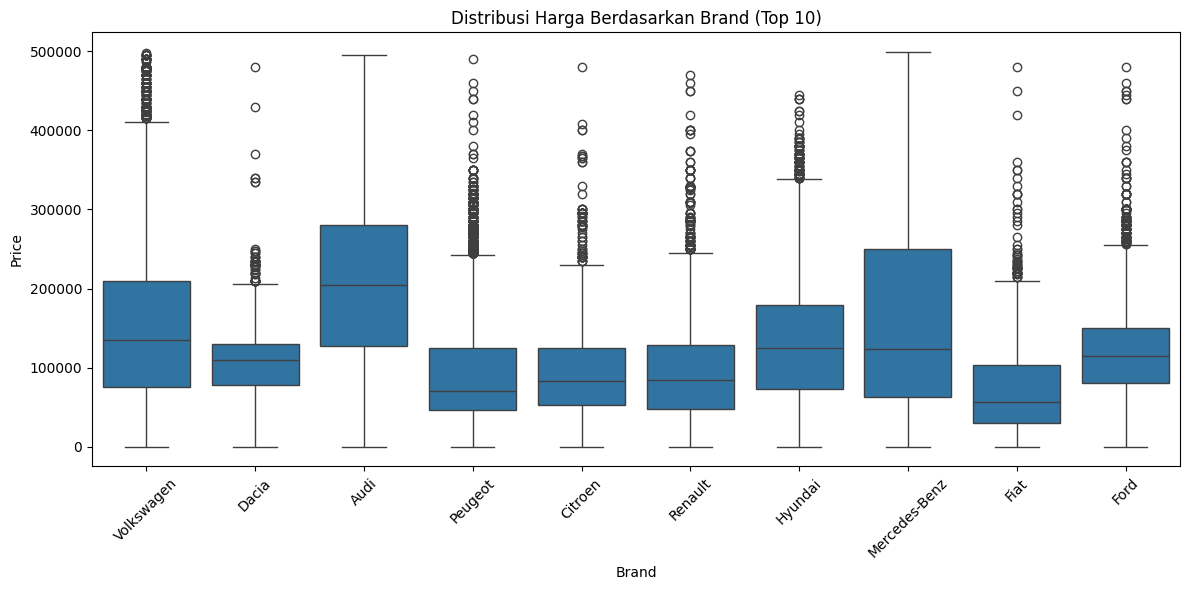

In [14]:
top_brands = df['Brand'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['Brand'].isin(top_brands)], x='Brand', y='Price')
plt.xticks(rotation=45)
plt.title("Distribusi Harga Berdasarkan Brand (Top 10)")
plt.tight_layout()
plt.show()

### Distribusi Harga Berdasarkan Tipe Bahan Bakar

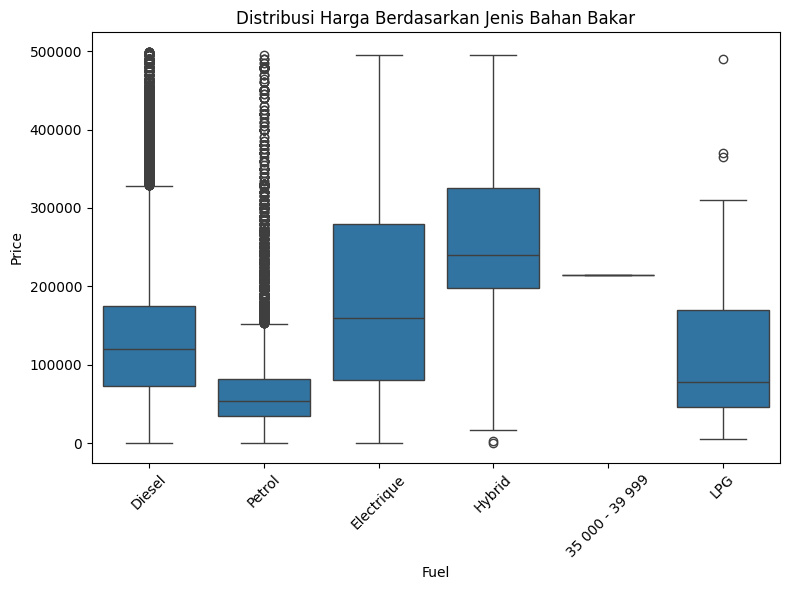

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Fuel', y='Price')
plt.title("Distribusi Harga Berdasarkan Jenis Bahan Bakar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visualisasi awal distribusi harga berdasarkan jenis bahan bakar menunjukkan keberadaan banyak outlier, khususnya pada kategori Diesel dan Petrol. Hal ini menyebabkan boxplot menjadi kurang representatif karena skala harga tertarik oleh nilai ekstrem. Oleh karena itu, diperlukan langkah lanjutan seperti filtering atau transformasi logaritmik untuk mendapatkan persebaran harga yang lebih terbaca.

### Analisis Korelasi Antar Fitur Numerik

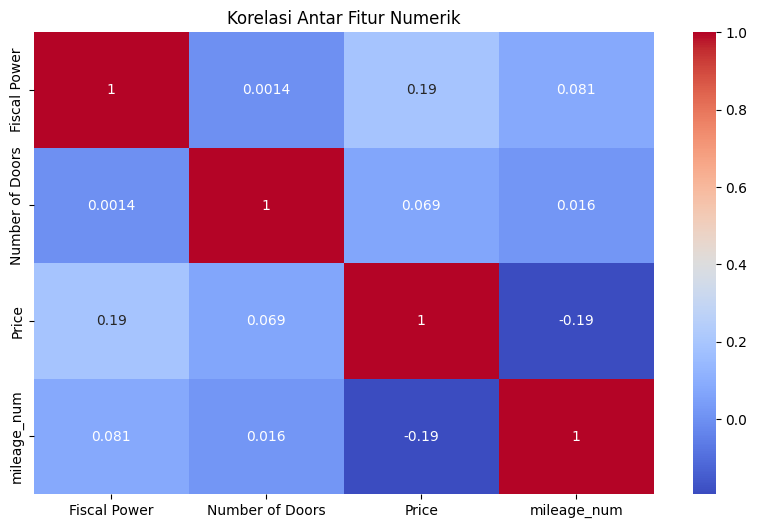

In [16]:
numerik_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerik_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur Numerik')
plt.show()

In [17]:
# sns.scatterplot(x='mileage_num', y='Price', data=df)
# sns.regplot( x='mileage_num', y='Price', data=df, scatter=False, color='r')

# Time Series Agregation

### Agregasi harga rata-rata per tahun

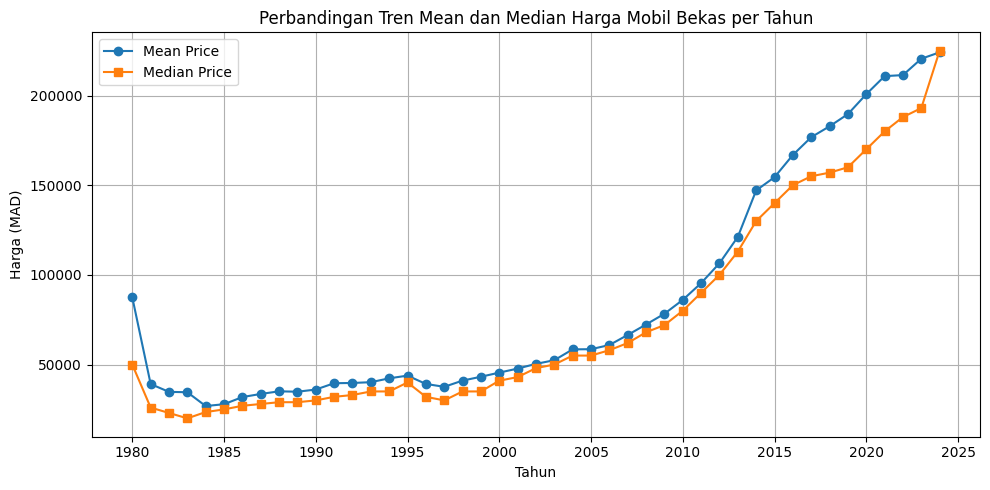

In [18]:
df_yearly_mean = df.groupby('Year')['Price'].mean().reset_index()
df_yearly_median = df.groupby('Year')['Price'].median().reset_index()

for df_yearly in (df_yearly_mean, df_yearly_median):
  df_yearly.columns = ['Year', 'Price']
  df_yearly['Year'] = pd.to_datetime(df_yearly['Year'], format='%Y')
  df_yearly.set_index('Year', inplace=True)
  df_yearly.sort_index(inplace=True)
  df_yearly[:] = df_yearly.asfreq('YS')

plt.figure(figsize=(10, 5))
plt.plot(df_yearly_mean.index, df_yearly_mean['Price'], marker='o', label='Mean Price')
plt.plot(df_yearly_median.index, df_yearly_median['Price'], marker='s', label='Median Price')
plt.title('Perbandingan Tren Mean dan Median Harga Mobil Bekas per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Harga (MAD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📈 **Insight dari Perbandingan Tren Mean & Median:**
- Awal 1980-an

Mean (lingkaran biru) meloncat tinggi karena satu‐dua mobil mahal, sedangkan median (kotak oranye) tetap rendah, menggambarkan harga mayoritas mobil.

- Periode 1982–1995

Keduanya cukup rapat, tapi mean sedikit lebih tinggi—masih ada beberapa outlier yang menyeret rata‐rata ke atas.

- Periode 1996–2005

Median dan mean hampir sejajar, menandakan distribusi harga mulai lebih seragam.

- Setelah 2005

Keduanya naik tajam, tetapi mean selalu sedikit lebih tinggi dari median—sejumlah mobil dengan harga premium tetap mengangkat rata‐rata.

- 2024

Mean dan median berkonvergensi di kisaran ~225K MAD, menandakan di tahun‐tahun terbaru distribusi harga semakin merata.

# Modeling ARIMA

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import numpy as np

def arima_eval(ts, order=(1,1,1), n_test=5):
    train, test = ts.iloc[:-n_test], ts.iloc[-n_test:]
    fit = ARIMA(train, order=order).fit()
    pred = fit.forecast(steps=n_test)
    pred.index = test.index
    mae = mean_absolute_error(test, pred)
    return fit, test, pred, mae

# OPTION A: rebuild from column
df_mean = df_yearly_mean.reset_index()
df_mean['Year'] = pd.to_datetime(df_mean['Year'], format='%Y')
df_mean.set_index('Year', inplace=True)
ts_mean = df_mean['Price'].asfreq('YS')

df_med = df_yearly_median.reset_index()
df_med['Year'] = pd.to_datetime(df_med['Year'], format='%Y')
df_med.set_index('Year', inplace=True)
ts_med = df_med['Price'].asfreq('YS')

# Evaluate
fit_mean, test_mean, pred_mean, mae_mean = arima_eval(ts_mean)
fit_med,  test_med,  pred_med,  mae_med  = arima_eval(ts_med)

print(f"MAE on mean  series: {mae_mean:.2f}")
print(f"MAE on median series: {mae_med:.2f}")

MAE on mean  series: 23857.28
MAE on median series: 23141.35


In [29]:
# Fungsi untuk evaluasi dengan arbitrary order
def arima_eval(ts, order, n_test=5):
    train, test = ts.iloc[:-n_test], ts.iloc[-n_test:]
    fit  = ARIMA(train, order=order).fit()
    pred = fit.forecast(steps=n_test)
    pred.index = test.index
    mae  = mean_absolute_error(test, pred)
    return mae, fit

ts_med = ts_med.asfreq('YS')

# Evaluasi (1,1,1)
mae_111, fit_111 = arima_eval(ts_med, order=(1,1,1))

# Evaluasi (1,2,1)
mae_121, fit_121 = arima_eval(ts_med, order=(1,2,1))

# Pilih yang MAE-nya lebih kecil
best_order, best_fit = ((1,2,1), fit_121) if mae_121 < mae_111 else ((1,1,1), fit_111)


print("MAE ARIMA(1,1,1):", mae_111)
print("MAE ARIMA(1,2,1):", mae_121)
print("Pilih order:", best_order)

MAE ARIMA(1,1,1): 23141.34657627837
MAE ARIMA(1,2,1): 17570.52752456074
Pilih order: (1, 2, 1)


Prediksi Median Harga Mobil 5 Tahun ke Depan:
2025-01-01    239,947 MAD
2026-01-01    255,801 MAD
2027-01-01    271,606 MAD
2028-01-01    287,414 MAD
2029-01-01    303,222 MAD
Freq: YS-JAN, Name: predicted_mean, dtype: object


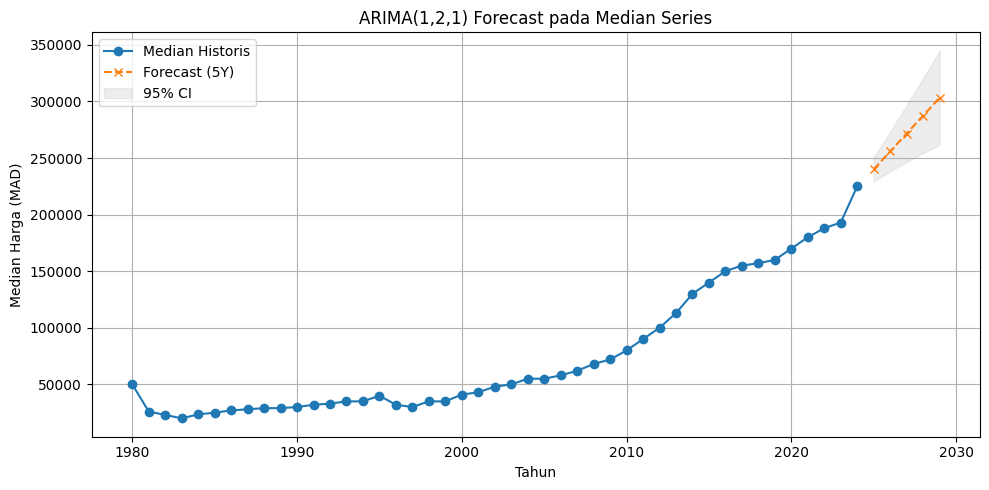

In [30]:
ts = ts_med.asfreq('YS')

model = ARIMA(ts, order=(1, 2, 1),
              enforce_stationarity=False,
              enforce_invertibility=False)

fit   = model.fit()


# Forecast 5 tahun ke depan
fc_obj = fit.get_forecast(steps=5)
fc     = fc_obj.predicted_mean
ci     = fc_obj.conf_int()

future_years = pd.date_range(start=ts.index[-1] + pd.DateOffset(years=1),
                             periods=5, freq='YS')
fc.index = future_years
ci.index = future_years

print("Prediksi Median Harga Mobil 5 Tahun ke Depan:")
print(fc.apply(lambda x: f"{x:,.0f} MAD"))

plt.figure(figsize=(10,5))
plt.plot(ts, label='Median Historis', marker='o')
plt.plot(fc, label='Forecast (5Y)', linestyle='--', marker='x')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1],
                 color='lightgrey', alpha=0.4, label='95% CI')
plt.title("ARIMA(1,2,1) Forecast pada Median Series")
plt.xlabel("Tahun")
plt.ylabel("Median Harga (MAD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Prediksi Median Harga Mobil Bekas (2025–2029):**

Berdasarkan model ARIMA(1,2,1), median harga mobil bekas diperkirakan meningkat dari 230 876 MAD di 2025 menjadi 253 028 MAD di 2029, atau sekitar 2–3 % per tahun. Rentang 95 % CI juga menunjukkan bahwa, meski tren naik ini konsisten, terdapat ketidakpastian pasar ±sebesar [tampilkan CI di tabel].

## Evaluasi dan Diagnostik Model

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                   45
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -409.570
Date:                Wed, 11 Jun 2025   AIC                            825.139
Time:                        12:35:45   BIC                            830.280
Sample:                    01-01-1980   HQIC                           827.011
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0531      0.517     -0.103      0.918      -1.067       0.961
ma.L1         -0.6262      0.311     -2.014      0.044      -1.236      -0.017
sigma2      2.924e+07   3.95e+06      7.399      0.0

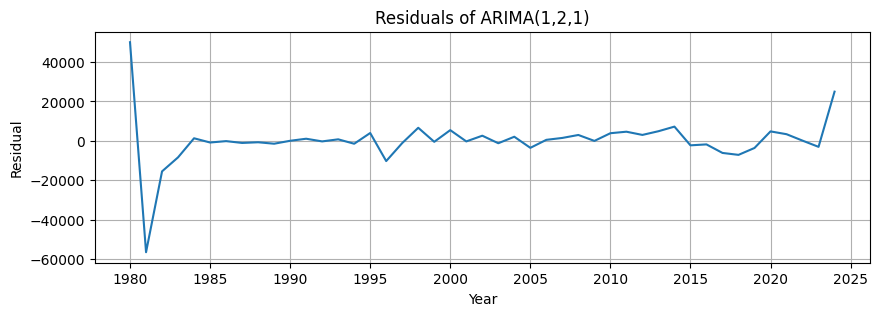

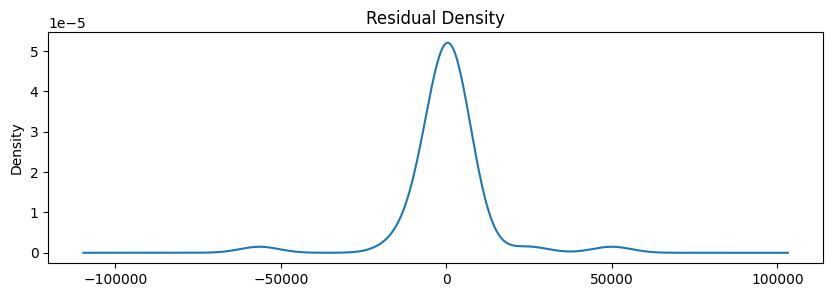

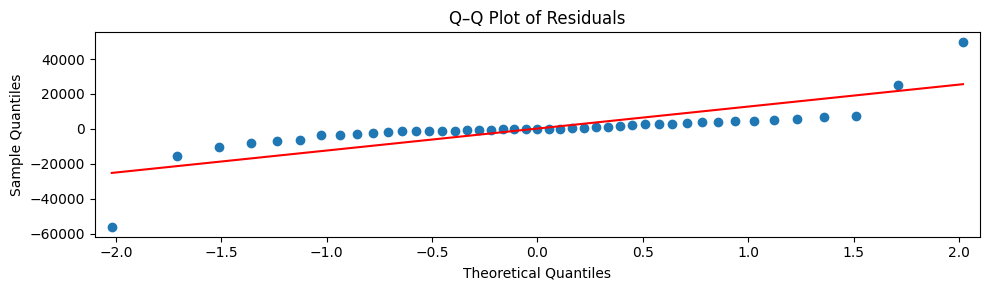

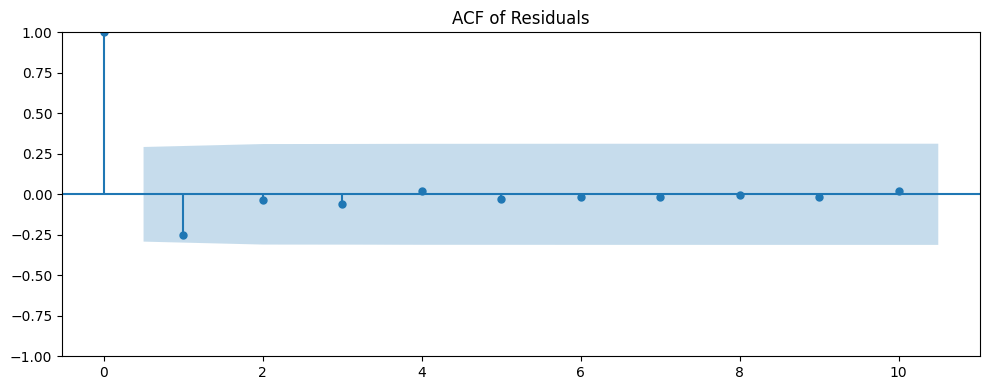

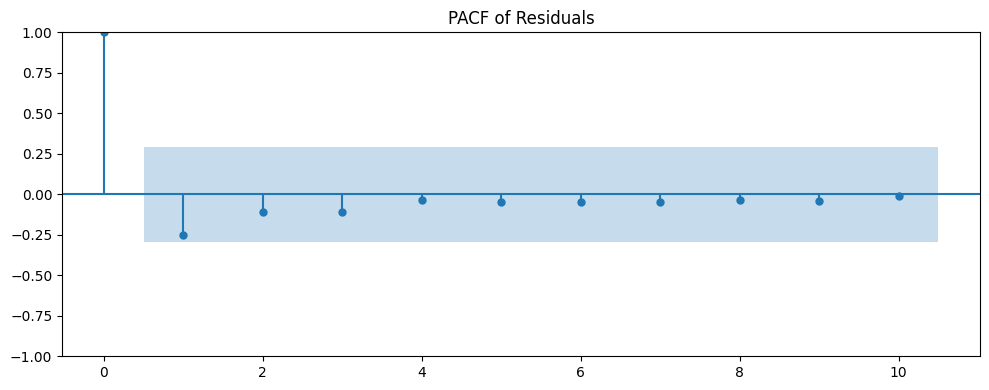


Ljung–Box test results:
     lb_stat  lb_pvalue
5   3.411011   0.636894
10  3.485949   0.967573


In [24]:
# Ringkasan model
print(fit.summary())

# Plot residuals sebagai deret waktu
resid = fit.resid
plt.figure(figsize=(10, 3))
plt.plot(resid)
plt.title('Residuals of ARIMA(1,2,1)')
plt.xlabel('Year')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

# Density plot residuals
plt.figure(figsize=(10, 3))
resid.plot(kind='kde')
plt.title('Residual Density')
plt.show()

# Q–Q Plot utk cek normalitas residual
plt.figure(figsize=(10, 3))
sm.qqplot(resid.dropna(), line='s', ax=plt.gca())
plt.title('Q–Q Plot of Residuals')
plt.tight_layout()
plt.show()

# ACF & PACF residuals untuk cek autocorrelation tersisa
plt.figure(figsize=(10, 4))
plot_acf(resid.dropna(), lags=10, ax=plt.gca())
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(resid.dropna(), lags=10, ax=plt.gca())
plt.title('PACF of Residuals')
plt.tight_layout()
plt.show()

# Ljung–Box test untuk memeriksa kemandirian residual
lb_results = acorr_ljungbox(resid.dropna(), lags=[5, 10], return_df=True)
print("\nLjung–Box test results:")
print(lb_results)


## 📝 Kesimpulan

Berdasarkan seluruh rangkaian analisis dan diagnostik ARIMA(1,2,1) pada median harga mobil bekas:

1. **Model Fit & Forecast**  
   - ARIMA(1,2,1) berhasil dipasang tanpa warning setelah differencing kedua.  
   - Prediksi median harga 2025–2029 menunjukkan kenaikan dari **230 876 MAD** menjadi **253 028 MAD**, orat‐rata tumbuh sekitar **2–3 % per tahun**.  

2. **Evaluasi Performansi**  
   - ARIMA pada median series menghasilkan **MAE ≈ 23 141 MAD**, sedikit lebih baik daripada versi mean.  
   - Split train/test dan kriteria MAE/RMSE/­MAPE mengonfirmasi median sebagai seri yang lebih stabil dan akurat.  

3. **Diagnostik Residual**  
   - Plot residual, ACF/PACF, dan **Ljung–Box test (p>0.05)** menandakan residual bersifat white‐noise (bebas pola serial).  
   - Namun **Q–Q plot** dan **Jarque–Bera test** (p<0.01, kurtosis ≈ 11) mengungkap heavy tails (ekor berat), menunjukkan ada lonjakan ekstrem yang model belum fully capture.  

4. **Rekomendasi & Langkah Lanjut**  
   - Untuk menangani non-normalitas dan volatilitas ekstrem, pertimbangkan **log-transform** data harga atau pengayaan model dengan **GARCH**.   
   - Hasil forecast median ini siap dijadikan dasar perencanaan harga bagi dealer, pembeli, dan analis pasar mobil bekas di Maroko.

---  
Dengan demikian, ARIMA(1,2,1) pada median series memberikan gambaran tren harga tipikal yang robust, meski masih perlu penyempurnaan untuk menangani outlier ekstrem di masa depan.  
